# Preparing the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

## Data initializing

Due to uselessness of `Speaker_Number` column we prefer to drop this information from our dataset.

In [2]:
data = pd.read_csv('../data/vowel.csv', sep = ',', header = 0)
data.drop('Speaker_Number', axis = 1, inplace = True)
data.head()

,Sex,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Class
0,Male,-3.639,0.418,-0.670,1.779,-0.168,1.627,-0.388,0.529,-0.874,-0.814,hid
1,Male,-3.327,0.496,-0.694,1.365,-0.265,1.933,-0.363,0.510,-0.621,-0.488,hId
2,Male,-2.120,0.894,-1.576,0.147,-0.707,1.559,-0.579,0.676,-0.809,-0.049,hEd
3,Male,-2.287,1.809,-1.498,1.012,-1.053,1.060,-0.567,0.235,-0.091,-0.795,hAd
4,Male,-2.598,1.938,-0.846,1.062,-1.633,0.764,0.394,-0.150,0.277,-0.396,hYd


## Filling in missing values

Let's classify the type for each column in the dataset. This helps us to fill in the gaps and choose what to do with data.

In [3]:
data_description = data.describe(include=[object])
numerical_features = [f for f in data.columns if data[f].dtype.name != 'object']
categorical_features = [f for f in data.columns if data[f].dtype.name == 'object']
binary_categorical_features = [f for f in categorical_features if data_description[f]['unique'] == 2]
non_binary_categorical_features = [f for f in categorical_features if data_description[f]['unique'] > 2]
print(numerical_features, binary_categorical_features, non_binary_categorical_features, sep = '\n')

['Feature_0', 'Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9']
['Sex']
['Class']


Now we can fill in the gaps if they exist.

In [4]:
if (data.count(axis = 0).max() != data.count(axis = 0).min()):
    data = data.fillna(data.median(axis = 0), axis = 0)
    for f in categorical_features:
        data[f] = data[f].fillna(data_description[f]['top'])
    print('The gaps are filled in')
else:
    print('There are no gaps')

There are no gaps


## Normalization



In [5]:
for f in numerical_features:
    data[f] = (data[f] - data[f].mean()) / data[f].std()
data.head()

,Sex,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Class
0,Male,-0.500881,-1.245468,-0.227868,1.664140,0.207128,1.650610,-0.830511,0.335683,-1.001513,-1.229600,hid
1,Male,-0.141843,-1.179100,-0.261578,1.118873,0.061176,2.157341,-0.776390,0.302541,-0.557779,-0.689852,hId
2,Male,1.247130,-0.840455,-1.500433,-0.485318,-0.603884,1.538003,-1.243996,0.592092,-0.887510,0.036987,hEd
3,Male,1.054953,-0.061912,-1.390874,0.653948,-1.124496,0.711668,-1.218018,-0.177136,0.371782,-1.198142,hAd
4,Male,0.697065,0.047850,-0.475077,0.719801,-1.997198,0.221497,0.862398,-0.848684,1.017213,-0.537530,hYd


## Vectorization

We can easily vectorize the binary features automatically. Let's choose the top value and assign `1` if our value is top and `0` if not.

In [6]:
for f in binary_categorical_features:
    true_items = data[f] == data_description[f]['top']
    false_items = np.logical_not(true_items)
    data.loc[true_items, f] = 1
    data.loc[false_items, f] = 0

On this stage we should decade the method of vectorization for non-binary features. Let's clone the dataset and use two different methods:
1. Naive method: let's map each value to a number.
2. Smarter method: let's use [One-hot mapping](https://en.wikipedia.org/wiki/One-hot).

In [7]:
data_naive = data.copy()

mapping_naive = dict()
for f in non_binary_categorical_features:
    for i, k in enumerate(data_naive[f].unique()):
        if not k in mapping_naive.keys():
            mapping_naive[k] = i
    data_naive[f] = data_naive[f].map(mapping_naive)
data_naive.head()

,Sex,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Class
0,1,-0.500881,-1.245468,-0.227868,1.664140,0.207128,1.650610,-0.830511,0.335683,-1.001513,-1.229600,0
1,1,-0.141843,-1.179100,-0.261578,1.118873,0.061176,2.157341,-0.776390,0.302541,-0.557779,-0.689852,1
2,1,1.247130,-0.840455,-1.500433,-0.485318,-0.603884,1.538003,-1.243996,0.592092,-0.887510,0.036987,2
3,1,1.054953,-0.061912,-1.390874,0.653948,-1.124496,0.711668,-1.218018,-0.177136,0.371782,-1.198142,3
4,1,0.697065,0.047850,-0.475077,0.719801,-1.997198,0.221497,0.862398,-0.848684,1.017213,-0.537530,4


In [8]:
data_smarter = data.copy()

for f in non_binary_categorical_features:
    data_smarter = pd.concat([data_smarter.drop(f, axis = 1), pd.get_dummies(data_smarter[f])], axis = 1)
data_smarter.head()

,Sex,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,...,hEd,hId,hOd,hUd,hYd,had,hed,hid,hod,hud
0,1,-0.500881,-1.245468,-0.227868,1.664140,0.207128,1.650610,-0.830511,0.335683,-1.001513,...,0,0,0,0,0,0,0,1,0,0
1,1,-0.141843,-1.179100,-0.261578,1.118873,0.061176,2.157341,-0.776390,0.302541,-0.557779,...,0,1,0,0,0,0,0,0,0,0
2,1,1.247130,-0.840455,-1.500433,-0.485318,-0.603884,1.538003,-1.243996,0.592092,-0.887510,...,1,0,0,0,0,0,0,0,0,0
3,1,1.054953,-0.061912,-1.390874,0.653948,-1.124496,0.711668,-1.218018,-0.177136,0.371782,...,0,0,0,0,0,0,0,0,0,0
4,1,0.697065,0.047850,-0.475077,0.719801,-1.997198,0.221497,0.862398,-0.848684,1.017213,...,0,0,0,0,1,0,0,0,0,0


## Data decomposition

Unfortunately, our algorithm has problems with very big datasets. We have to choose only one third of the initial data randomly.

In [9]:
def compress_data(data):
    n = len(data.index)
    return data.drop(np.random.choice(data.index, int(n * 1 / 3), replace = False))

data_naive = compress_data(data_naive)
data_smarter = compress_data(data_smarter)

And now we need choose features which are related to the objects and which are target.

In [10]:
x_naive = data_naive.drop('Class', axis = 1).values.tolist()
y_naive = data_naive.loc[:, ['Class']].values.tolist()

x_smarter = data_smarter.drop(data['Class'].unique(), axis = 1).values.tolist()
y_smarter = data_smarter[data['Class'].unique()].values.tolist()

# Classification

Lets define our parameters which we will look over.

In [11]:
metrics = {
    "euclidean":    lambda x, y: sum([abs(x[i] - y[i]) ** 2 for i in range(len(x))]) ** (1 / 2),
    "manhattan":    lambda x, y: sum([abs(x[i] - y[i]) for i in range(len(x))]),
    "chebyshev":    lambda x, y: max([abs(x[i] - y[i]) for i in range(len(x))])
}

kernels = {
    "uniform":      lambda x: 0 if abs(x) >= 1 else 1 / 2,
    "triangular":   lambda x: 0 if abs(x) >= 1 else 1 - abs(x),
    "epanechnikov": lambda x: 0 if abs(x) >= 1 else 3 / 4 * (1 - x ** 2),
    "quartic":      lambda x: 0 if abs(x) >= 1 else 15 / 16 * (1 - x ** 2) ** 2,
    "triweight":    lambda x: 0 if abs(x) >= 1 else 35 / 32 * (1 - x ** 2) ** 3,
    "tricube":      lambda x: 0 if abs(x) >= 1 else 70 / 81 * (1 - abs(x) ** 3) ** 3,
    "cosine":       lambda x: 0 if abs(x) >= 1 else math.pi / 4 * math.cos(math.pi / 2 * x),
    "gaussian":     lambda x: 1 / (math.sqrt(2 * math.pi)) * math.e ** (-0.5 * x ** 2),
    "logistic":     lambda x: 1 / (math.e ** x + 2 + math.e ** (-x)),
    "sigmoid":      lambda x: 1 / (math.e ** x + math.e ** (-x)) * 2 / math.pi
}

windows = {
    "fixed":        lambda distances, h: h,
    "variable":     lambda distances, h: sorted(distances)[h]
}

class Params:
    def __init__(self, metric, kernel, window, h):
        self.metric = metric
        self.kernel = kernel
        self.window = window
        self.h = h
    
    def __str__(self):
        return "[" + ", ".join([self.metric, self.kernel, self.window, str(self.h)]) + "]"

Our predicting function is based on [KNN algorithm](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm). `x` and `y` are features of the dataset (object and target), `params` are defined in previous cell and `q` is index of row which is a query for the current prediction.

In [12]:
def predict(x, y, params, q):
    n, m = len(y), len(y[0])
    
    weight_sum = 0
    result = [0 for j in range(m)]
    y_sum = [sum([y[i][j] for i in range(n)]) for j in range(m)]
    
    distances = [metrics[params.metric](x[i], x[q]) for i in range(n) if i != q]
    w = windows[params.window](distances, params.h)

    for i, distance in enumerate(distances):
        weight = kernels[params.kernel](distance / w if w != 0 else 0) if distance == 0 or w != 0 else 0
        weight_sum += weight
        for j in range(m):
            result[j] += weight * y[i if i < q else i + 1][j]
    for j in range(m):
        if weight_sum == 0:
            result[j] = (y_sum[j] - y[q][j]) / (n - 1)
        else:
            result[j] /= weight_sum
    return result

For the algorithm assessment we will use [F1-score](https://en.wikipedia.org/wiki/F1_score). More specifically, we will use macro- (or, optionally, micro-) version of F1-score.

In [13]:
def f1_score(cn, mode = "macro"):
    k, s = len(cn), sum(map(sum, cn))
    tp, fp, fn = [0 for i in range(k)], [0 for i in range(k)], [0 for i in range(k)]
    for i in range(k):
        tp[i] += cn[i][i]
        for j in range(k):
            if i != j:
                fp[i] += cn[i][j]
                fn[j] += cn[i][j]
    precision = [0 if tp[i] + fp[i] == 0 else tp[i] / (tp[i] + fp[i]) for i in range(k)]
    recall = [0 if tp[i] + fn[i] == 0 else tp[i] / (tp[i] + fn[i]) for i in range(k)]
    
    if mode == "macro":
        precision_weighted = sum([(tp[i] + fn[i]) * precision[i] for i in range(k)]) / s
        recall_weighted = sum([(tp[i] + fn[i]) * recall[i] for i in range(k)]) / s
        sum_weighted = precision_weighted + recall_weighted
        return 0 if sum_weighted == 0 else 2 * recall_weighted * precision_weighted / sum_weighted
    elif mode == "micro":
        f1 = [0 if tp[i] == 0 else 2 * recall[i] * precision[i] / (recall[i] + precision[i]) for i in range(k)]
        return sum([(tp[i] + fn[i]) * f1[i] for i in range(k)]) / s

Our [leave-one-out cross validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)#Leave-one-out_cross-validation) will generate [confusing matrix](https://en.wikipedia.org/wiki/Confusion_matrix), based on the prediction results, and calculate F1 score for the matrix.

In [14]:
def count_classes(y):
    return len(np.unique(y)) if len(y[0]) == 1 else len(y[0])

def correct_classes(u):
    return int(np.round(u)) if len(u) == 1 else np.argmax(u)

def leave_one_out(x, y, params):
    n, k = len(x), count_classes(y)
    matrix = [[0 for j in range(k)] for i in range(k)]
    for q in range(n):
        y_real = correct_classes(y[q])
        y_predicted = correct_classes(predict(x, y, params, q))
        matrix[y_predicted][y_real] += 1
    return matrix, f1_score(matrix)

And finally, we should look over our parameters for guessing best ones (based on F1 score statistics).

In [15]:
def guess_parameters(x, y):    
    best_f1 = 0
    for metric in metrics.keys():
        for kernel in kernels.keys():
            for window in windows.keys():
                for h in range(1, 4):
                    params = Params(metric, kernel, window, h)
                    matrix, f1 = leave_one_out(x, y, params)
                    if f1 >= best_f1:
                        best_f1 = f1
                        best_params = params
    return best_params

# Analyzing

The external function `analyze` will find best parameters and reproduce the algorithm with them. Also, it's useful to have graph for F1 score from `h` parameter.

In [16]:
def analyze(x, y):
    best_params = guess_parameters(x, y)
    matrix, f1 = leave_one_out(x, y, best_params)
    print("best params:", best_params)
    print("best f1-score:", f1)
    print(pd.DataFrame(matrix))
    print()
    
    scores = []
    for h in range(1, 13):
        params = Params(best_params.metric, best_params.kernel, best_params.window, h)
        matrix, score = leave_one_out(x, y, params)
        scores.append(score)
    plt.plot(range(1, 13), scores)
    plt.xlabel("h")
    plt.ylabel("f1-score")
    plt.show()

## Analyzing naive dataset

best params: [manhattan, cosine, variable, 1]
best f1-score: 0.9687249767928594
     0   1   2   3   4   5   6   7   8   9  10
0   62   0   0   0   0   0   0   0   0   0   0
1    1  67   0   0   0   0   0   0   0   0   0
2    0   0  55   0   0   0   0   0   0   0   0
3    0   0   0  53   0   0   0   0   0   0   0
4    0   0   0   0  56   0   3   0   1   0   0
5    0   0   0   2   2  53   0   0   0   0   2
6    0   0   0   0   0   0  66   2   0   0   0
7    0   0   0   0   0   0   0  55   3   0   0
8    0   0   0   0   0   0   0   0  61   0   0
9    0   0   0   0   0   0   0   0   0  54   0
10   0   0   0   0   0   3   0   0   1   1  57



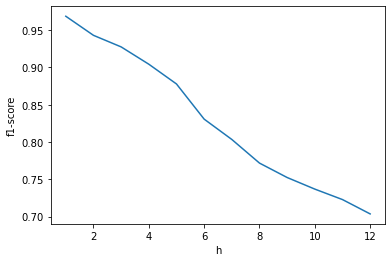

In [17]:
analyze(x_naive, y_naive)

## Analyzing smarter dataset

best params: [manhattan, cosine, variable, 3]
best f1-score: 0.9744151082066352
     0   1   2   3   4   5   6   7   8   9  10
0   58   0   0   0   0   0   0   0   0   0   0
1    1  54   0   0   0   0   0   0   0   0   0
2    0   2  55   0   0   0   0   0   0   0   1
3    0   0   0  58   0   0   0   0   0   0   0
4    0   0   0   0  56   0   2   0   0   0   0
5    0   0   0   0   1  65   0   0   1   0   1
6    0   0   0   0   1   0  63   0   0   0   0
7    0   0   0   0   0   0   0  57   0   0   0
8    0   0   0   0   0   0   0   2  53   0   1
9    0   0   0   0   0   0   0   0   0  64   0
10   0   0   0   0   0   2   0   0   2   0  60



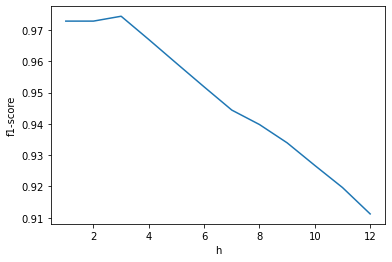

In [18]:
analyze(x_smarter, y_smarter)